# $z > 0.4$

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import emcee
import corner
import scipy.stats as stats

import sys
sys.path.append("../")
from pyACC.cosmology import Dc_w0waCDM

### Hubble Function

In [104]:
H0=68
Omega_r=0
def hubble_function(z,Omega_m,Omega_r,w0,wa,H0):
    return H0*np.sqrt(Omega_m*(1+z)**3+Omega_r*(1+z)**4+(1-Omega_m-Omega_r)*(1+z)**(3*(1+w0+wa))*np.exp(-3*wa*z/(1+z)))

### File

In [105]:
file_path = 'lcparam_full_long.txt'

with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

z_data = data['zcmb'].values
mb = data['mb'].values #B-band peak magnitude
dmb = data['dmb'].values

Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

### Distance Modulus

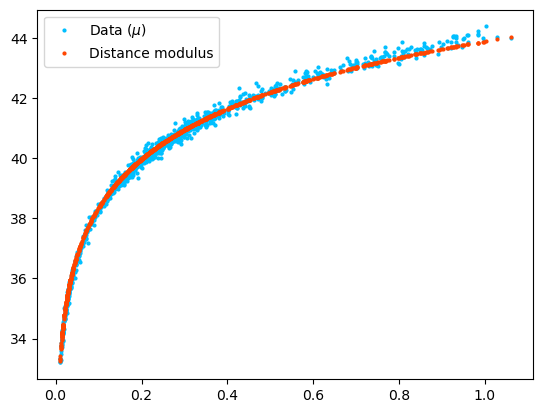

In [106]:
def get_mu(z,H0,Omega_r,Omega_m,w0,wa):
    comoving_distance=[]
    distance_modulus=[]

    for i in range(len(z)):
        comoving_distance.append(Dc_w0waCDM(hubble_function,z[i],Omega_m,Omega_r,w0,wa,H0))
        #print(comoving_distance[i])
        if comoving_distance[i]<=0:
            print(f"Invalid distance value: {comoving_distance[i]} for index {i} with redshift {z[i]}")
        distance_modulus.append(5*np.log10(comoving_distance[i]*(1+z[i]))+25)
        #print(distance_modulus[i])
    '''
    for i in range(len(z)):
        # Compute comoving distance
        dc = Dc_w0waCDM(hubble_function, z[i], Omega_m, Omega_r, w0, wa, H0)
        comoving_distance.append(dc)

        # Calculate distance * (1 + z)
        distance = dc * (1 + z[i])
        if distance <= 0:
            print(f"Error at index {i}: Invalid distance value {distance} for comoving_distance {dc} and redshift {z[i]}")
            sys.exit("Stopping execution due to invalid distance value.")

        # Compute distance modulus
        modulus = 5 * np.log10(distance) + 25
        distance_modulus.append(modulus)
    '''
    return np.array(distance_modulus)

#distance modulus of the data: mu_data=mb-M with M the absolute magnitude of a type Ia supernova, so M=-19.3
M=-19.3
mu_data=mb-M

plt.plot(z_data,mu_data,'o',markersize=2,color='deepskyblue',label='Data ($\mu$)')
plt.plot(z_data,get_mu(z_data,68,0.319,0,-1,0),'o',markersize=2,color='orangered',label='Distance modulus')
plt.legend()
plt.show()

Isolating $z>0.4$

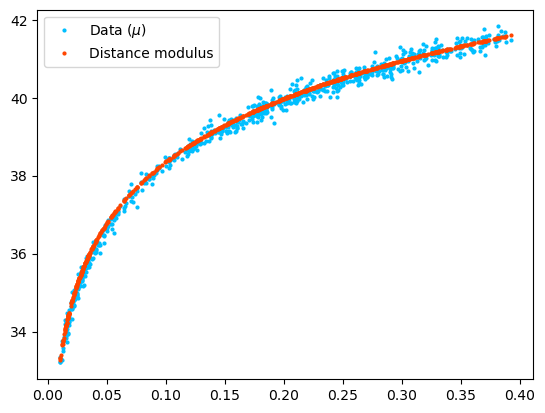

In [107]:
z_data_high=[]
mu_data_high=[]
dmb_high=[]
for i in range(len(z_data)):
    if z_data[i]<0.4:
        z_data_high.append(z_data[i])
        mu_data_high.append(mu_data[i])
        dmb_high.append(dmb[i])

z_data_high=np.array(z_data_high)
mu_data_high=np.array(mu_data_high)
dmb_high=np.array(dmb_high)

Sigma_high = np.diag(dmb_high**2)
Sigma_inv_high = np.linalg.inv(Sigma_high)

plt.plot(z_data_high,mu_data_high,'o',markersize=2,color='deepskyblue',label='Data ($\mu$)')
plt.plot(z_data_high,get_mu(z_data_high,68,0.319,0,-1,0),'o',markersize=2,color='orangered',label='Distance modulus')
plt.legend()
plt.show()

### Prior

In [108]:
def log_prior(params):
    Omega_m, w0, wa = params
    if 0 < Omega_m < 1 and -2 < w0 < 0 and -2 < wa < 2:
        return 0
    return -np.inf

### Likelihood

In [109]:
def log_likelihood(params,z,d,cov_inv):
    Omega_m,w0,wa=params
    if Omega_m<0:
        #print(f"Omega_m out of bounds: {Omega_m}")
        return -np.inf
    if Omega_r<0:
        #print(f"Omega_r out of bounds: {Omega_r}")
        return -np.inf
    mu=get_mu(z,H0,Omega_r,Omega_m,w0,wa)
    diff=d-mu
    #return -0.5 * diff @ cov_inv @ diff
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2
    '''
    if np.any(np.isnan(params)):
        print(f"NaN value found in params: {params}")
        return -np.inf
    if len(z)==len(z_data):
        return term1+term2
    else:
        return term1
    '''

### Posterior

In [110]:
def log_posterior(params,z,d,cov_inv):
    prior = log_prior(params)
    if np.isfinite(prior):
        return prior + log_likelihood(params,z,d,cov_inv)
    return prior

### $\chi ^2$

In [111]:
def chi(params,z,d,cov_inv):
    return -2*log_posterior(params,z,d,cov_inv)

## Parameter Optimization

In [112]:
initial_guess = [0.319, -1, 0]

result = minimize(chi, initial_guess, args=(z_data_high, mu_data_high, Sigma_inv_high), method='Powell')
best_fit_params = result.x

mu_model_best = get_mu(z_data_high, H0, Omega_r, *best_fit_params)

/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2577: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


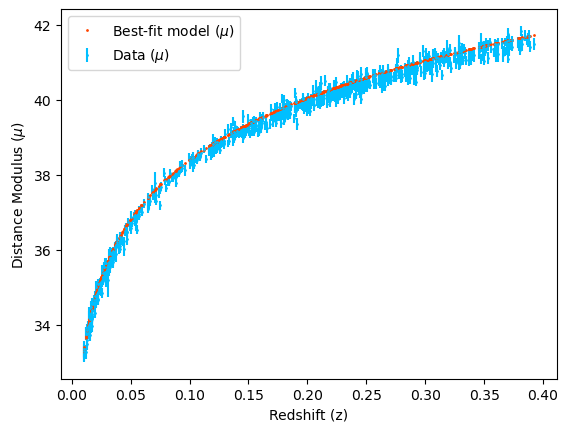

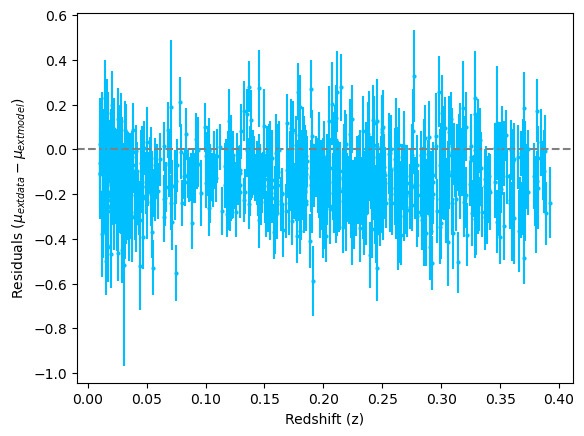

--------------------------------------
Best-fit parameters:
Omega_m: 0.19120768422315218
w0: -1.0890356955997789
wa: 1.9999907468689324
--------------------------------------
Chi-square: 778.8439980398358
Degrees of freedom: 763
Reduced chi-square: 1.0207653971688542
--------------------------------------


In [113]:
plt.errorbar(z_data_high, mu_data_high, yerr=dmb_high, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data_high, mu_model_best, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

residuals = mu_data_high - mu_model_best
plt.errorbar(z_data_high, residuals, yerr=dmb_high, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

print("--------------------------------------")
print("Best-fit parameters:")
print("Omega_m:", best_fit_params[0])
print("w0:", best_fit_params[1])
print("wa:", best_fit_params[2])
print("--------------------------------------")
chi2 = -2 * log_posterior(best_fit_params, z_data_high, mu_data_high, Sigma_inv_high)
print("Chi-square:", chi2)
print("Degrees of freedom:", len(z_data_high) - len(best_fit_params))
print("Reduced chi-square:", chi2 / (len(z_data_high) - len(best_fit_params)))
print("--------------------------------------")

## MCMC

In [114]:
# Initialize the MCMC sampler
initial = np.array([0.319, -1, 0])
ndim = len(initial)
nwalkers = 50

std_Om0 = 1e-2
#std_Omr = 1e-7
std_w0_wa = 1e-1

# Create the initial positions with different standard deviations
pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_Om0 * np.random.randn(nwalkers)
#pos[:, 1] = initial[1] + std_Omr * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_w0_wa * np.random.randn(nwalkers)

#'''
# Check initial likelihoods
for i in range(nwalkers):
    print(log_likelihood(pos[i], z_data_high, mu_data_high, Sigma_inv_high))

# Check initial posteriors
for i in range(nwalkers):
    print(log_posterior(pos[i], z_data_high, mu_data_high, Sigma_inv_high))
#'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data_high, mu_data_high, Sigma_inv_high))

-392.3544562333162
-390.57127405433073
-391.7453116378294
-391.08533007183064
-390.4779097171373
-398.32709650524265
-390.51519079979266
-391.6010460042158
-394.27014910195965
-390.90147651470164
-394.41300850058843
-390.4386941695082
-396.14283892115463
-399.91155835288936
-390.63074497676854
-390.3679682882119
-391.41483933658736
-392.49953888046866
-390.99051764699635
-390.67978605570624
-399.770838119675
-390.5804779713927
-396.1615335439335
-391.6639072625173
-391.6923377407704
-392.3311063891569
-392.1117113402002
-392.2548117516247
-392.82279559321444
-391.62777427458
-390.3852996457339
-392.30259731557226
-391.41689933696847
-390.5445966428585
-391.05612275967246
-395.3796760060874
-390.4723300464331
-398.98737288145105
-390.6149977244808
-392.2517131823826
-398.49774814439064
-398.1532154067245
-390.8611461153186
-396.18595010848304
-399.6737525255895
-390.560480945567
-391.4831525645637
-403.9863895088273
-390.559980328422
-390.3824340613562
-392.3544562333162
-390.5712740543

In [115]:
# Run the MCMC sampler
nsteps = 500
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=100,thin=10,flat=True)

100%|██████████| 500/500 [19:13<00:00,  2.31s/it]


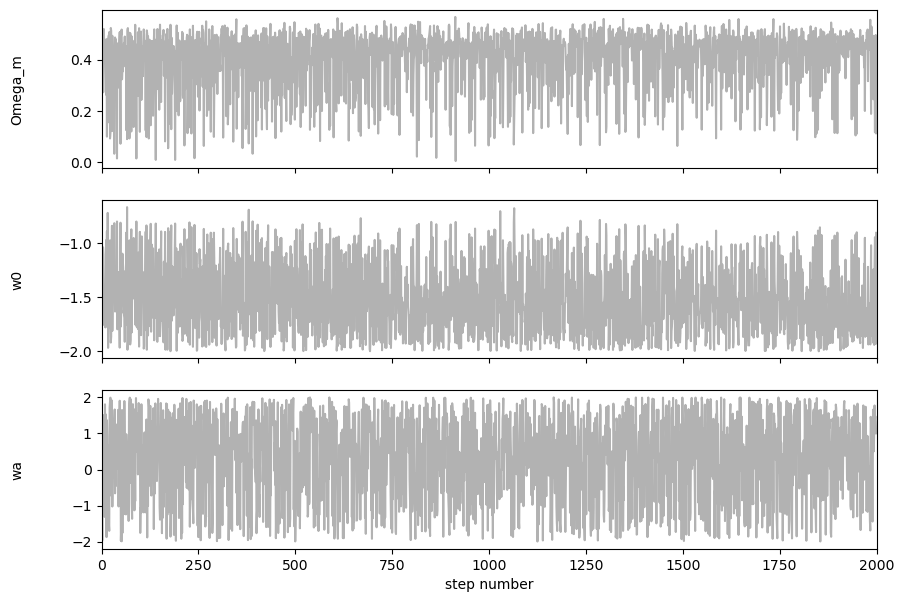

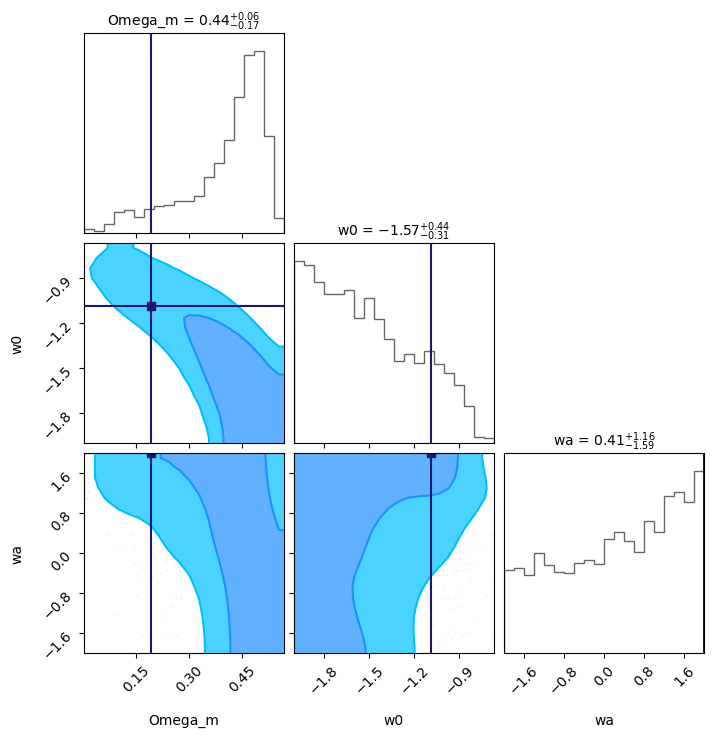

In [116]:
reshaped_samples = samples.reshape(-1, samples.shape[-1])

#plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Omega_m", "w0", "wa"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(reshaped_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(reshaped_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

#'mediumvioletred'
#'hotpink', 'deeppink'

#'midnightblue'
#'deepskyblue', 'dodgerblue'

level_colors = ['deepskyblue', 'dodgerblue']

contourf_kwargs = {
    "colors": ['white', 'deepskyblue', 'dodgerblue'],  # Colors for the filled contours
    "alpha": 0.7  # Transparency of the filled contours
}
fig = corner.corner(reshaped_samples,
                    labels=labels,
                    truths=best_fit_params,
                    truth_color='midnightblue',
                    plot_contours=True,
                    fill_contours=True,
                    levels=[0.68, 0.95],
                    smooth=2.0,
                    show_titles=True,
                    title_fmt=".2f",
                    title_kwargs={"fontsize": 10},
                    hist_kwargs={"density": True, "alpha": 0.6},
                    contour_kwargs={"colors": level_colors},
                    contourf_kwargs=contourf_kwargs
                    )
    
plt.show()

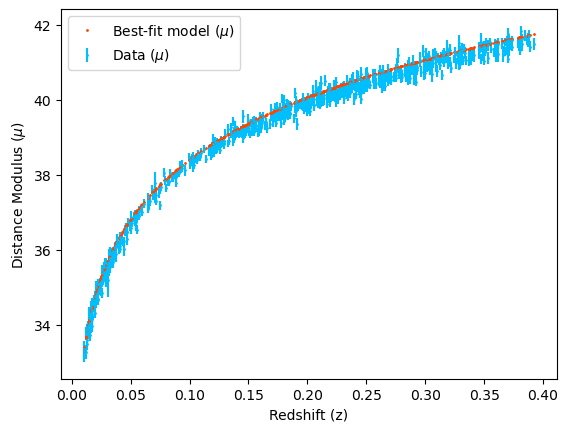

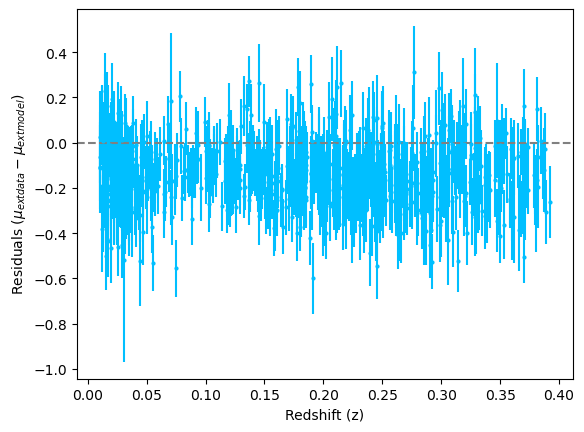

In [117]:
#plot the best fit model
best_fit_params_mcmc = np.mean(reshaped_samples, axis=0)
best_fit_params_mcmc_std = np.std(reshaped_samples, axis=0)
mu_model_best_mcmc = get_mu(z_data_high, H0, Omega_r, *best_fit_params_mcmc)

plt.errorbar(z_data_high, mu_data_high, yerr=dmb_high, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data_high, mu_model_best_mcmc, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

#plot the residuals
residuals_mcmc = mu_data_high - mu_model_best_mcmc
plt.errorbar(z_data_high, residuals_mcmc, yerr=dmb_high, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

In [118]:
print("--------------------------------------")
print("Best-fit parameters (MCMC):")
print("Omega_m:", best_fit_params_mcmc[0], "+/-", best_fit_params_mcmc_std[0])
#print("Omega_r:", best_fit_params_mcmc[1], "+/-", best_fit_params_mcmc_std[1])
print("w0:", best_fit_params_mcmc[1], "+/-", best_fit_params_mcmc_std[1])
print("wa:", best_fit_params_mcmc[2], "+/-", best_fit_params_mcmc_std[2])
print("--------------------------------------")

--------------------------------------
Best-fit parameters (MCMC):
Omega_m: 0.40108475846895525 +/- 0.11726722105680044
w0: -1.5208753726155875 +/- 0.3272896531637664
wa: 0.2813213661206068 +/- 1.168582610599266
--------------------------------------


### Statistics

In [119]:
samples_Omega_m = reshaped_samples[:, 0]
#samples_Omega_r = reshaped_samples[:, 1]
samples_w0 = reshaped_samples[:, 1]
samples_wa = reshaped_samples[:, 2]

samples_dict = {
    "Omega_m": samples_Omega_m,
    #"Omega_r": samples_Omega_r,
    "w0": samples_w0,
    "wa": samples_wa
}

for key, value in samples_dict.items():
    print(f"Mean of {key}: {np.mean(value)}")
    print(f"Standard deviation of {key}: {np.std(value)}")
    print(f"Median of {key}: {np.median(value)}")
    print(f"68% credible interval of {key}: {np.percentile(value, [16, 84])}")
    print(f"95% credible interval of {key}: {np.percentile(value, [2.5, 97.5])}")
    print(f"Skewness of {key}: {stats.skew(value)}")
    print(f"Kurtosis of {key}: {stats.kurtosis(value)}")
    print("--------------------------------------")

Mean of Omega_m: 0.401084758468955
Standard deviation of Omega_m: 0.1172672210568004
Median of Omega_m: 0.44170394019714004
68% credible interval of Omega_m: [0.27416282 0.49980763]
95% credible interval of Omega_m: [0.1097323  0.53379376]
Skewness of Omega_m: -1.2120564019857607
Kurtosis of Omega_m: 0.6785753281911497
--------------------------------------
Mean of w0: -1.5208753726155864
Standard deviation of w0: 0.32728965316376635
Median of w0: -1.5655941520678114
68% credible interval of w0: [-1.8792979  -1.12155729]
95% credible interval of w0: [-1.98413592 -0.87367583]
Skewness of w0: 0.4279519623391256
Kurtosis of w0: -0.8776243888326238
--------------------------------------
Mean of wa: 0.28132136612060676
Standard deviation of wa: 1.1685826105992658
Median of wa: 0.4131472553780281
68% credible interval of wa: [-1.17185821  1.57091324]
95% credible interval of wa: [-1.87385537  1.94951176]
Skewness of wa: -0.30297504428792266
Kurtosis of wa: -1.1347271961075425
---------------

**N.B.:**

* positive skewness: the distribution has a long tail on the right side;
* negative skewness: the distribution has a long tail on the left side;
* kurtosis > 3: the distribution has heavy tails and a sharp peak, indicating a higher likelihood of extreme values;
* kurtosis < 3: the distribution has light tails and a flatter peak, indicating a lower likelihood of extreme values.